# Project for IST 652
### Author: Jack R. O'Connor

This project looks at team data of games of the online MOBA League of Legends. This data set consists of 10,000 games played in the Diamond I to Master tier ranks. There are 19 primary features in this dataset which are mirrored for each team giving 38 total features. These, combined with a game ID and a game outcome, comprise the 40 columns. The data was pulled after 10 minutes of game play, but the average game of LoL is ~35 minutes. This ensures that each game is comparable to the others by collecting the data at the same time. 

Data: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

# Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from itertools import chain

# Import Data

In [2]:
data = pd.read_csv("high_diamond_ranked_10min.csv")
data

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,4527797466,1,54,0,0,6,4,8,1,1,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,4527713716,0,23,1,0,6,7,5,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


In [3]:
#Check for NAs
data.isnull().sum()

gameId                          0
blueWins                        0
blueWardsPlaced                 0
blueWardsDestroyed              0
blueFirstBlood                  0
blueKills                       0
blueDeaths                      0
blueAssists                     0
blueEliteMonsters               0
blueDragons                     0
blueHeralds                     0
blueTowersDestroyed             0
blueTotalGold                   0
blueAvgLevel                    0
blueTotalExperience             0
blueTotalMinionsKilled          0
blueTotalJungleMinionsKilled    0
blueGoldDiff                    0
blueExperienceDiff              0
blueCSPerMin                    0
blueGoldPerMin                  0
redWardsPlaced                  0
redWardsDestroyed               0
redFirstBlood                   0
redKills                        0
redDeaths                       0
redAssists                      0
redEliteMonsters                0
redDragons                      0
redHeralds    

In [4]:
# Change the bluWins column to a category dtype
#data['blueWins'] = data["blueWins"].astype('category')

In [5]:
# Remove some columns that are represented twice by "inverse association"
    ## If blue gets first blood then red does not. Blue's deaths are represented (almost always) by Red's kills, 
    ## and vice versa. Elite monsters is just dragons + heralds
cols = ['gameId', 'redFirstBlood', 'blueDeaths', 'redDeaths', 'redGoldDiff', 'redExperienceDiff', 'blueEliteMonsters',
        'redEliteMonsters']
data_clean = data.drop(cols, axis = 1)

# EDA

0    4949
1    4930
Name: blueWins, dtype: int64


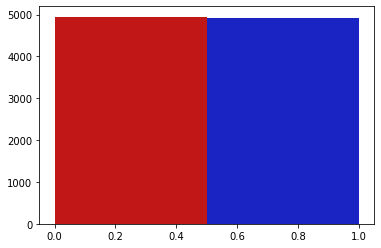

In [6]:
# Distribution of blue's wins and losses
colors = ['#c21717', '#1924c2']
numbins=2
n, bins, patches = plt.hist(data['blueWins'], bins = numbins)

# apply the same color for each class to match the map
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
print(data['blueWins'].value_counts())
## Code help from https://github.com/matplotlib/matplotlib/issues/11487

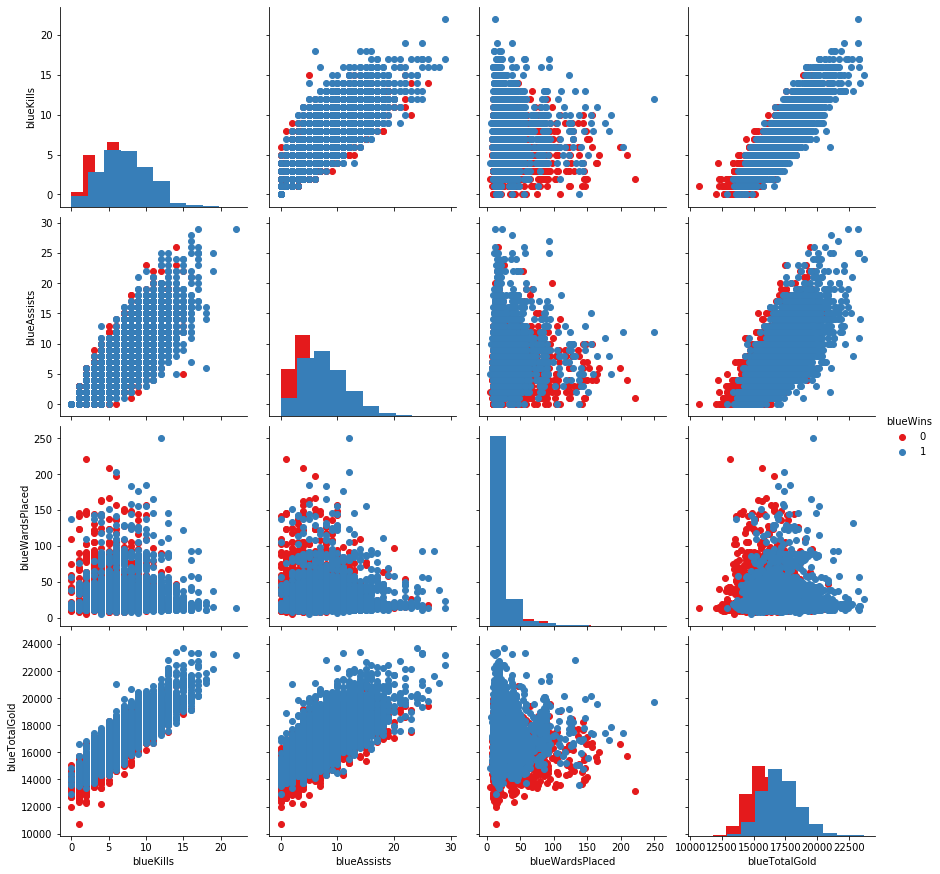

In [7]:
# Next let's check the relationship between parameters of blue team features
g = sns.PairGrid(data=data_clean, vars=['blueKills', 'blueAssists', 'blueWardsPlaced', 'blueTotalGold'],
                 hue='blueWins', height=3, palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

#Code help from https://www.kaggle.com/xiyuewang/lol-how-to-win

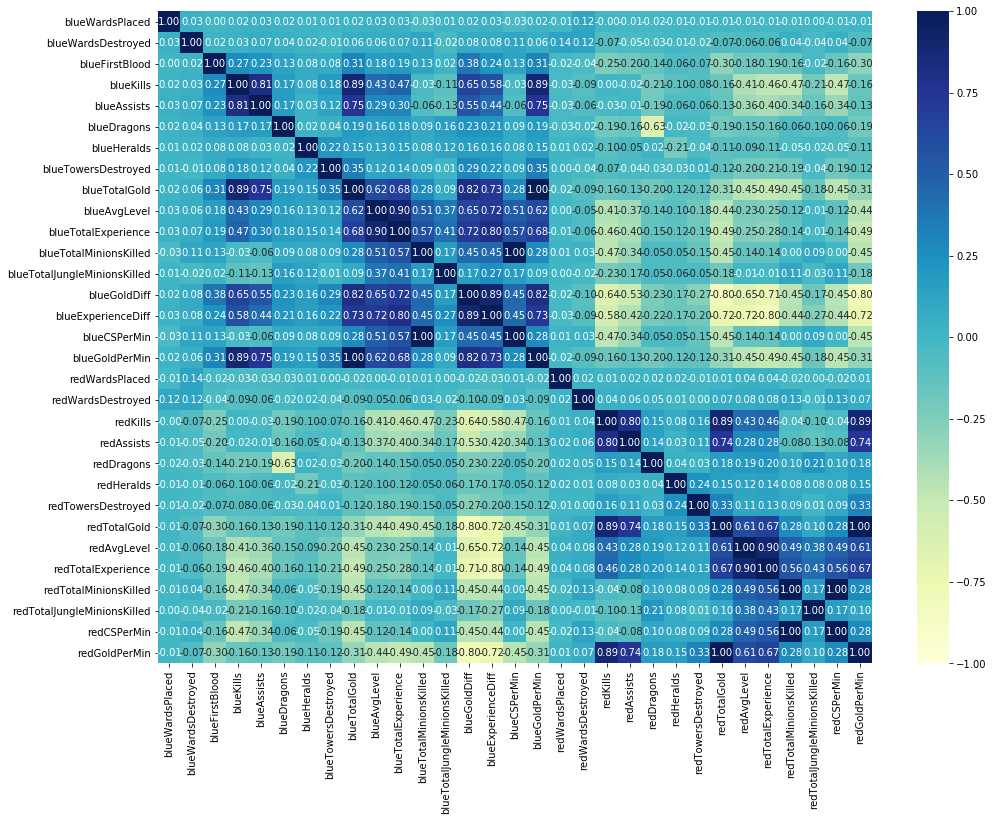

In [8]:
# Correlation Matrix testing for multicollinearity
plt.figure(figsize=(16, 12))
sns.heatmap(data_clean.drop('blueWins', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

In [9]:
cols = ['blueAvgLevel', 'redAvgLevel', 'blueTotalExperience', 'redTotalExperience', 'redCSPerMin', 'blueCSPerMin',
        'redGoldPerMin', 'blueGoldPerMin', 'blueTotalGold', 'redTotalGold']
data_clean = data_clean.drop(cols, axis=1)

In [10]:
# Combining Assists and kill (1 assist = .5 kill)
# Source: https://leagueoflegends.fandom.com/wiki/Kill#:~:text=1000%20gold%20earned%20from%20CS%20or%20by%20earning%20an%20assist.&text=50%20to%20the%20assist%20bounty.&text=200%20gold%20their%20advantage%20grows,the%20player%20loses%20the%20advantage.
bassist = data_clean['blueAssists'].tolist()
rassist = data_clean['redAssists'].tolist()
assist1=[]
for i in bassist:
    assist1.append(float(i)*.5)
data_clean['blueKills'] = data_clean['blueKills'] + assist1

assist2 = []
for i in rassist:
    assist2.append(float(i)*.5)
data_clean['redKills'] = data_clean['redKills'] + assist2

In [11]:
# Drop assists columns for both teams
cols = ['blueAssists', 'redAssists']
data_clean = data_clean.drop(cols, axis=1)

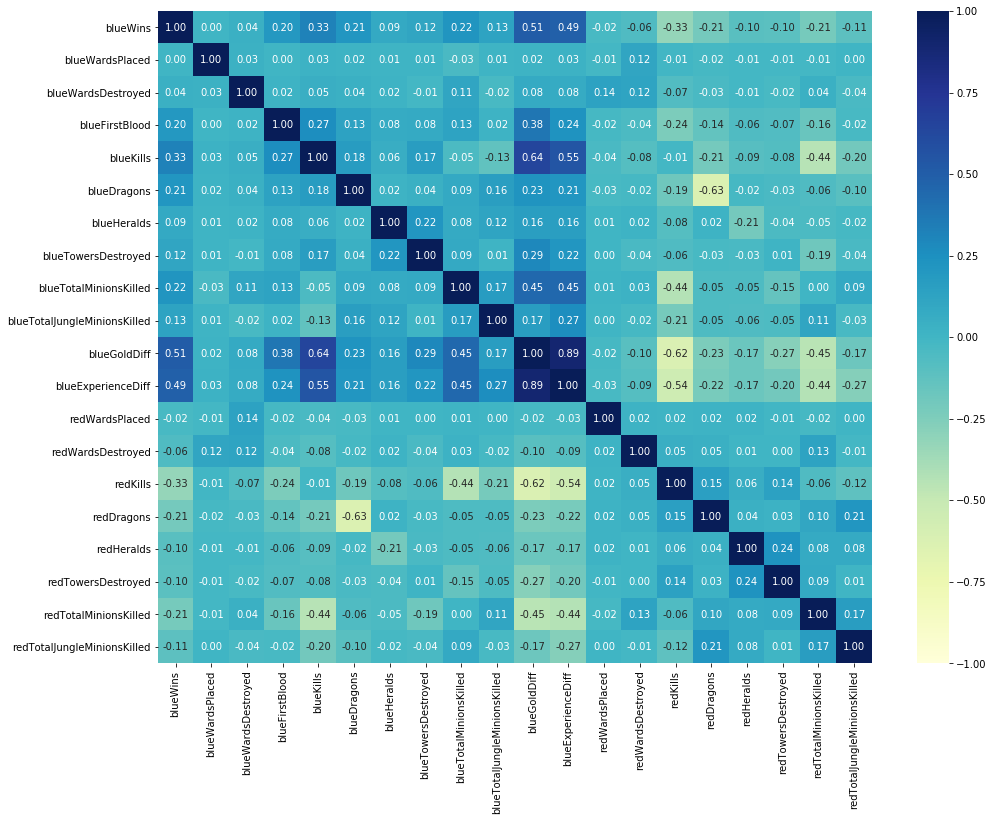

In [12]:
# Correlation Matrix looking at relationship to 'blueWins'
plt.figure(figsize=(16, 12))
sns.heatmap(data_clean.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

In [13]:
# Looking at which variables are highly correlated with blueWins
## First line grabs the correlations to blueWins for all the other columns
### It takes the df from column 1 to the end (excludes blueWins) and applies the lambda function to that subset
### The lambda function takes one argument (our df minus blueWins) and correlates each column to blueWins
corr_list = data_clean[data_clean.columns[1:]].apply(lambda x: x.corr(data_clean['blueWins'])) 
cols = []
### This loop grabs the index (column name) from the corr_list created above and iterates through the list.
### corr_list is technically a pandas series - not a list. 
### If the correlation value is > 0.2 or < -0.2 the index is appended to cols list 
for col in corr_list.index:
    if (corr_list[col] > 0.2 or corr_list[col] < -0.2):
        cols.append(col)
cols

['blueFirstBlood',
 'blueKills',
 'blueDragons',
 'blueTotalMinionsKilled',
 'blueGoldDiff',
 'blueExperienceDiff',
 'redKills',
 'redDragons',
 'redTotalMinionsKilled']

In [14]:
# Override data_clean with the cols most correlated with blueWins. THIS DOES NOT INCLUDE BLUEWINS SO THAT MUST BE ADDED FROM
## DATA DF
data_clean = data_clean[cols]

# Models

In [15]:
# Separate train and test data 
X = data_clean #Independent variables
y = data['blueWins'] #Classification

scaler = MinMaxScaler() #Normalization scaler (used in HW02)
scaler.fit(X) #In order to normalize both training and testing sets:
    ## sklearn will save the stdev and mean as internal objects to be used in the transform function below 
X = scaler.transform(X)
#Code help from https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Code help from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Random Forest 

In [16]:
randomf = RandomForestClassifier()

# Use the GridSearchCV funciton to explore the best parameters for RF
grid = {'n_estimators': [100,200,300,400,500], 'max_depth': [2,5,10]}

rf_params = GridSearchCV(randomf, grid, cv=5)
rf_params.fit(X_train, y_train)

predicted_randomf = rf_params.predict(X_test)

accuracy_rf = accuracy_score(predicted_randomf, y_test)
print(accuracy_rf)

0.729757085020243


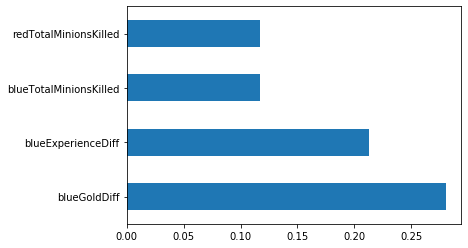

In [17]:
# List featrue importance for Random Forest model using 500 estimators
rf = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=data_clean.columns)
feat_importances.nlargest(4).plot(kind='barh')

# Code help from https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

In [18]:
# Removing Exp and Gold diff features 
collist = data_clean.columns.tolist()
collist.remove('blueGoldDiff')
collist.remove('blueExperienceDiff')

rf_data = data_clean[collist]

# Separate train and test data 
rf_X = rf_data #Independent variables
rf_y = data['blueWins'] #Classification

scaler = MinMaxScaler() #Normalization scaler (used in HW02)
scaler.fit(rf_X) #In order to normalize both training and testing sets:
    ## sklearn will save the stdev and mean as internal objects to be used in the transform function below 
rf_X = scaler.transform(rf_X)
#Code help from https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models

rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=0.2, random_state=42)

In [19]:
randomf = RandomForestClassifier()

# Use the GridSearchCV funciton to explore the best parameters for RF
grid = {'n_estimators': [100,200,300,400,500], 'max_depth': [2,5,10]}

rf_params2 = GridSearchCV(randomf, grid, cv=5)
rf_params2.fit(rf_X_train, rf_y_train)

predicted_randomf2 = rf_params2.predict(rf_X_test)

accuracy_rf2 = accuracy_score(predicted_randomf2, rf_y_test)
print(accuracy_rf2)

0.7125506072874493


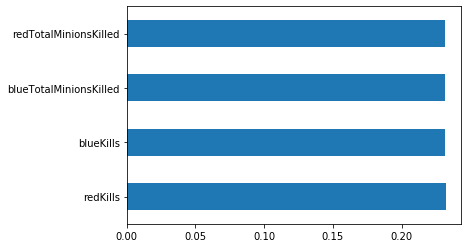

In [20]:
# List featrue importance for Random Forest model using 500 estimators
rf2 = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state=42)
rf2.fit(rf_X_train, rf_y_train)
feat_importances2 = pd.Series(rf2.feature_importances_, index=rf_data.columns)
feat_importances2.nlargest(4).plot(kind='barh')

## Naive Bayes

In [21]:
# Create and fit the model
classify_nb = GaussianNB()
classify_nb.fit(X_train, y_train)

# Apply trained model to test data
predict_nb = classify_nb.predict(X_test)

# Print accuracy
accuracy_nb = accuracy_score(predict_nb, y_test)
print(accuracy_nb)

0.7368421052631579


## Logistic Regression

In [22]:
# Create and fit the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Apply trained model to test data
predict_lr = lr.predict(X_test)

# Print Accuracy
accuracy_lr = accuracy_score(predict_lr, y_test)
print(accuracy_lr)

0.728744939271255


In [23]:
featcols = data_clean.columns.tolist()
for name, importance in zip(featcols, lr.coef_.tolist()):
    print(name, "=", importance)

blueFirstBlood = [0.1338586762690842, 0.7572257395889194, 0.31498255784923257, 0.00816553853218096, 6.176955161632731, 4.856234745702455, -0.8108904811366964, -0.22166517792746954, 0.06089973880909091]


In [30]:
coef = lr.coef_.tolist()
coef = list(chain.from_iterable(coef))
#coef_df = pd.DataFrame(featcols, coef, index = featcols)
test = {featcols[i]: coef[i] for i in range(len(coef))} 
sort_test = sorted(test.items(), key=lambda x: x[1], reverse=True)
for i in sort_test:
    print(i[0], i[1])

blueGoldDiff 6.176955161632731
blueExperienceDiff 4.856234745702455
blueKills 0.7572257395889194
blueDragons 0.31498255784923257
blueFirstBlood 0.1338586762690842
redTotalMinionsKilled 0.06089973880909091
blueTotalMinionsKilled 0.00816553853218096
redDragons -0.22166517792746954
redKills -0.8108904811366964


In [31]:
acc_dict = {'Naive Bayes': [accuracy_nb], 'Random Forest 1': [accuracy_rf], 'Random Forest 2': [accuracy_rf2], 'Logistic Regression': [accuracy_lr]}
df_c = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['Accuracy Score'])
print(df_c)

                     Accuracy Score
Naive Bayes                0.736842
Random Forest 1            0.729757
Random Forest 2            0.712551
Logistic Regression        0.728745


In [32]:
df_c.to_csv("Model Accuracies")